# Data Preparation

Before training the model, the data must be processed so that it can be in the acceptable form when feeding to the neural net. Also, some cleaning and wrangling will be required for the data. The following things should be considered:

 - Cleaning / preprocessing data:
     - remove emojis (apply to inputs)
     - remove hashtags (apply to inputs)
     - remove user mentions (apply to inputs)
     - remove urls (apply to inputs)
     - convert text to lower case (apply to inputs)
     - remove rows with a rating that is not a integer between 1 - 5 (don't apply to inputs)
 - Dealing with large data set, batch processing.
 - Determine label / sentiment distribution and try to sample as evenly as possible accross the different classes i.e. good, average, poor.
 - Quantization of text for inputing into the neural net.

## 1. Cleaning / Preprocessing data

This [Medium article](https://towardsdatascience.com/text-preprocessing-for-data-scientist-3d2419c8199d) had detailed implementations for many text preprocessing tasks, including removing emojis.

### 1.1 Explore the data

In [1]:
import pandas as pd

raw_data_dir = '../data/raw/scraped_data.csv'
# Read data in as chunks, and keep only relevant columns i.e. text comment, and label rating
df = pd.read_csv('../data/raw/scraped_data.csv', 
                 chunksize=100_000, 
                 usecols=['comment', 'rating'],
                 encoding='utf-8',
                 nrows=None,
                 sep=',')

def check_basic_data_stats(data):
    
    len_data = 0
    memory_usage = pd.Series(dtype='object')
    
    for chunk in data:
        # Determine length of dataset
        len_data += len(chunk)
    
        # Determine memory usage of dataframe
        if len(memory_usage) == 0:
            memory_usage = chunk.memory_usage(deep=True)/1e6
        else:
            memory_usage += chunk.memory_usage(deep=True)/1e6

    print(f'Number of reviews scraped from Trustpilot: {len_data:,} reviews\n')
    print(f'Memory usage per column (MB):\n{memory_usage}\n')
    print(f'Total memory usage of dataframe: {memory_usage.sum()/1e3:.2f} GB\n')
    return chunk # this is the last chunk in the entire data set, return for display

In [9]:
check_basic_data_stats(df).head()

Number of reviews scraped from Trustpilot: 5,980,003 reviews

Memory usage per column (MB):
Index         0.007916
comment    2006.976003
rating       47.840024
dtype: float64

Total memory usage of dataframe: 2.05 GB



,comment,rating
5900000,"excellent, love being able to read the bottle ...",5
5900001,"Fast delivery,love the items I've ordered & fa...",5
5900002,"So simple and easy to shop on line,I will orde...",5
5900003,Great bargains and quick delivery.,5
5900004,Grandson loved the books.,4


### 1.2 Removing emojis

Decided not to remove emoticons, since the character level CNN will learn the pattern in the emoticons. The reason to remove emojis is due to their encodings covering too wide of a range. In the future, maybe we can identify a few emojis that can be included in the input features since they do represent sentiments.

In [1]:
import re

# Function to remove emoji.
def remove_emoji(text: str) -> str:
    """
    Remove emojis from a input string of text.
    
    :param text: text to be processed.
    :type text: str
    :returns: processed text with emojis removed.
    :rtype: str
    """
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text).strip()

# Test function
print(remove_emoji("Hi, I am Emoji  😜"))
print(remove_emoji("No emojis here"))

Hi, I am Emoji
No emojis here


### 1.3 Removing hashtags

Regex [cheat sheet](https://www.rexegg.com/regex-quickstart.html)

In [2]:
import re

def remove_hashtags(text: str) -> str:
    """
    Remove hashtags from the input text. e.g. #happy
    
    :param text: text to be processed.
    :type text: str
    :returns: processed text with hashtags removed.
    :rtype: str
    """
    clean_text = re.sub(r'#[A-Za-z0-9_]+', "", text)
    return clean_text.strip()

# Test function
print(remove_hashtags("I am #happy #sad #ilovecoffee should not remove"))
print(remove_hashtags(" #happy #sad #ilovecoffee \nshould #not ?? remove"))
print(remove_hashtags("No hashtags here"))

I am    should not remove
should  ?? remove
No hashtags here


### 1.4 Removing user mentions

Regex [cheat sheet](https://www.rexegg.com/regex-quickstart.html)

In [3]:
import re

def remove_user_mentions(text: str) -> str:
    """
    Remove user mentions from the input text. e.g. @mason
    
    :param text: text to be processed.
    :type text: str
    :returns: processed text with user mentions removed.
    :rtype: str
    """
    clean_text = re.sub(r'@[A-Za-z0-9_]+', "", text)
    return clean_text.strip()

# Test function
print(remove_user_mentions("@mason, is this how you review products?"))
print(remove_user_mentions("hey, users @user1, @user2 and @user3"))
print(remove_user_mentions("No user mentions here"))

, is this how you review products?
hey, users ,  and
No user mentions here


### 1.5 Removing urls

Regex [cheat sheet](https://www.rexegg.com/regex-quickstart.html)

In [4]:
import re

def remove_urls(text: str) -> str:
    """
    Remove ulrs from the input text. e.g. https:\\www.google.com
    
    :param text: text to be processed.
    :type text: str
    :returns: processed text with urls removed.
    :rtype: str
    """
    url_pattern = re.compile(r'https?://\S+|www\.\S+')
    clean_text = re.sub(r'http\S+', '', text) # urls can span across many lines
    return clean_text.strip()

# Test function
print(remove_urls("Go to this website: https://trello.com/c/eZwkuQE1/3-phase-2-model-training"))
print(remove_urls("Go to this website: https://www.youtube.com/watch?v=WgAIi1c369k"))
print(remove_urls("No url here"))

Go to this website:
Go to this website:
No url here


### 1.6 Converting to lower case

Lets assume everyone knows how to dow this one...

In [5]:
def lower(text) -> str:
    """
    Convert input string to lower case.
    
    :param text: text to be processed.
    :type text: str
    :returns: processed text converted to lower case.
    :rtype: str
    """
    return text.lower()

### 1.7 Filtering out data with labels not a integer in the range of 1 - 5

In [6]:
from pandas import DataFrame, read_csv

def clean_label(batch: DataFrame, col: str) -> DataFrame:
    """
    Take an input dataframe (probably part of a batch process) and make sure that 
    the label columns contain all integers in the range of 1 - 5.
    
    :param batch: a dataframe.
    :type batch: DataFrame
    :param col: the label column.
    :type col: str
    :returns: a processed dataframe with the label column cleaned.
    :rtype: DataFrame
    """
    # First check if the label column has dtype of int
    int_check = batch[col].dtype == 'int'
    # If the column is already in integer format
    # only check if values are within range
    if int_check:
        batch = batch[batch[col].isin(range(1,6))]
    # If the column isn't in integer format
    # Filter out rows where label is not a number
    # Then check if values are within range
    else:
        num_rows = batch.shape[0]
        batch = batch[batch[col].str.isnumeric()]
        batch = batch.astype('int')
        batch = batch[batch[col].isin(range(1,6))]
        print(f"Found bad label: removed {batch.shape[0]-num_rows} rows.")
    return batch

# Testing function
# df = read_csv('../data/raw/scraped_data.csv', 
#                  chunksize=100_000, 
#                  usecols=['comment', 'rating'],
#                  encoding='utf-8',
#                  nrows=None,
#                  sep=',')
# for chunk in df:
#     clean_label(chunk, 'rating')

### 1.8 Create pipeline for preprocessing of data

In [7]:
from typing import Union, Iterator, Iterable, Generator
from pandas import DataFrame, read_csv
from pandas.io.parsers import TextFileReader

def preprocess_text(data: Union[str, DataFrame, TextFileReader], 
                    text_col: str='comment', 
                    label_col: str='rating') -> Union[str, DataFrame, Generator[DataFrame, None, None]]:
    """
    Applies preprocessing to input data. Allowed data types can be a input string of text, 
    a pandas DataFrame or a pandas TextFileReader. The latter input type generally occrurs 
    if the dataset is large and won't fit in memory as a whole. In that case, the returned 
    data is a generator. This can be thought of as chaining generators to produce a stream 
    of data that will fit in memory.
    
    :param data: The input text data to be preprocessed.
    :type data: Union[str, DataFrame, TextFileReader]
    :param text_col: The column of dataframe that contains the text data. If input is a 
                     single string, this parameter is ignored. Defaults to 'comment'
                     corresponding to the original dataset column name.
    :type text_col: str
    :param label_col: The column of dataframe that contains the label data. If input is a 
                      single string, this parameter is ignored. Defaults to 'rating'
                      corresponding to the original dataset column name.
    :type label_col: str
    :raise: TypeError if the input data format isn't either a str, DataFrame or TextFileReader.
    :returns: Preprocessed text data.
    :rtypes: Union[str, DataFrame, Generator[DataFrame, None, None]] 
    """
    preprocessing_steps = {
        'Removing emojis': remove_emoji,
        'Removing hashtags': remove_hashtags,
        'Removing user mentions': remove_user_mentions,
        'Removing urls': remove_urls,
        'Converting to lower case': lower
    }
    
    def preprocess_text_chunk(chunk: DataFrame) -> DataFrame:
        # Apply the preprocessing pipeline to a dataframe
        for step, func in preprocessing_steps.items():
            chunk[text_col] = chunk[text_col].apply(func)
        chunk = chunk.dropna()
        chunk = clean_label(chunk, label_col)
        return chunk
    
    # If input is a single instance of text, then we are making inference
    if isinstance(data, str):
        for step, func in preprocessing_steps.items():
            data = func(data)
        return data
    
    # If input is a dataframe, clean the dataframe and return it
    elif isinstance(data, DataFrame):
        return preprocess_text_chunk(data)

    # If input is a TextFileReader, 
    # clean it but return a generator to improve memory efficiency
    elif isinstance(data, TextFileReader):
        return (preprocess_text_chunk(chunk) for chunk in data)
    
    else:
        raise TypeError("""Allowed types are one of the following:
            - str, 
            - pandas.DataFrame
            - pandas.io.parsers.TextFileReader""")

In [8]:
# Test Functions
df = read_csv('../data/raw/scraped_data.csv', 
                 chunksize=100_000, 
                 usecols=['comment', 'rating'],
                 encoding='utf-8',
                 nrows=None,
                 sep=',')
# chunk = next(df)

In [201]:
# clean_chunk = preprocess_text(chunk)
clean_df = preprocess_text(df)

## 2. Preparing data for training

The pipeline will first clean and preprocess the data, then we need to prepare the data for training i.e. splitting the dataset into training and testing set (not using a validation set in this case). This will be needed only for training purposes, when making inference, there is no need to split the input and therefore we will not be expecting strings but dataframes or generators as input for this part of the pipeline.

Note that the raw data contains 5 classes within the label i.e. 1 - 5 star ratings. For the purpose of this project, we will group \[1,2\] stars to 'poor', 3 stars to 'average' and \[4,5\] stars to 'good'.

### 2.1 Determine Distribution of label data

In [8]:
from typing import Union, Generator
from pandas import DataFrame, Series
from matplotlib.ticker import FuncFormatter
from copy import deepcopy

def group_labels(data: Union[DataFrame, Generator[DataFrame, None, None]], 
                 label_col: str='rating') -> Union[DataFrame, Generator[DataFrame, None, None]]:
    """
    Assign new groups to old label classes.
    """
    def _assign_class(data: DataFrame):
        # Assign group of labels to a new set of classes 0,1,2 representing poor, average and bad
        data.loc[(data[label_col]==1) | (data[label_col]==2), label_col] = 0 # Group [1,2] to 0
        data.loc[(data[label_col]==3), label_col] = 1 # Group [3] to 1
        data.loc[(data[label_col]==4) | (data[label_col]==5), label_col] = 2 # Group [4,5] to 2
        return data
    
    if isinstance(data, DataFrame):
        return _assign_class(data)
    
    elif isinstance(data, Generator):
        return (_assign_class(chunk) for chunk in data)
    
    else:
        raise TypeError("""Allowed types are one of the following: 
            - pandas.DataFrame
            - Generator[pandas.DataFrame, None, None]""")

def label_class_fcount(data: Union[DataFrame, Generator[DataFrame, None, None]], 
                       label_col: str='rating') -> DataFrame:
    """
    Take either a dataframe or a generator of dataframes and return a Series representing 
    the frequency count of existing label classes. In addition, also calculate the corresponding 
    probability of each class.
    
    :param data: the data containing the label column for which class frequency count 
                 must be determined.
    :type data: Union[DataFrame, Generator[DataFrame, None, None]]
    :param label_col: The coloumn in the data for which frequency count must be determined.
                      Defaults to 'rating' corresponding ot the label column in the original data.
    :type label_col: str
    :raise: TypeError if the input data format isn't either a DataFrame or Generator[DataFrame, None, None].
    :return: frequency count of all distinct classes within the label data as well as their corresponding probabilities.
    :rtype: DataFrame
    """
    data = deepcopy(data)
    if isinstance(data, DataFrame):
        fcount = data[label_col].value_counts()
        sorted_idx = fcount.index.sort_values()
        fcount = fcount[sorted_idx]
        prob = fcount / fcount.sum()
        return DataFrame({'frequency': fcount, 'probability': prob})
    
    elif isinstance(data, Generator):
        fcount_total = None
        for chunk in data:
            if fcount_total is None:
                fcount_total = chunk[label_col].value_counts()
            else:
                fcount_total += chunk[label_col].value_counts()
        sorted_idx = fcount_total.index.sort_values()
        fcount_total = fcount_total[sorted_idx]
        prob = fcount_total / fcount_total.sum()
        return DataFrame({'frequency': fcount_total, 'probability': prob})
    
    else:
        raise TypeError("""Allowed types are one of the following: 
            - pandas.DataFrame
            - Generator[pandas.DataFrame, None, None]""")
        
def plot_label_dist(label_dist: DataFrame, plot_type: str='frequency') -> None:
    """
    Helper function to plot the label class distribution.
    
    :param label_dist: the label class distribution summary.
    :type label_dist: DataFrame
    :param plot_type: the type of plot to show. Can be 'frequency' or 'probability'.
    :type plot_type: str
    :return: Nothing
    :rtype: None
    """
    ax = label_dist[plot_type].plot.bar(figsize=(10,5))
    ax.grid()
    ax.get_yaxis().set_major_formatter(FuncFormatter(lambda x, p: format(x, ',.2f'))) # Set y axis 1000s separator
    ax.tick_params(axis='x', labelrotation=0) 
    ax.set_xlabel('Label Classes')
    ax.set_ylabel(plot_type)
    ax.set_title(f"Label class {plot_type}")

In [202]:
# Group data with different labels assigned to new classes
clean_df = group_labels(clean_df, 'rating')

# Get frequency count and probablity of each label class
# label_fcount = label_class_fcount(clean_df, 'rating')

   frequency  probability
0     570201     0.096973
1     234677     0.039911
2    5075125     0.863116


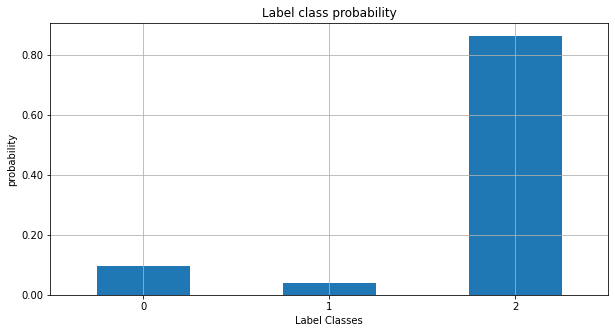

In [146]:
print(label_fcount)
plot_label_dist(label_fcount, plot_type='probability')

Looking at the distribution above, it's quite clear that most reviews on trustpilot are good reviews with 5 starts. If we group \[4,5\] as 'good', 3 as 'average' and \[1,2\] as 'poor', the respective distribution across the entire dataset for these classes will be 0.86, 0.04 and 0.1. This is of course not ideal for the following obvious reasons:

 - The model trained on this data might overfit to the good reviews.
 - If we don't sample properly, there is a good chance that we might end up with a training set that contains (let's be extreme) 99% good reviews, this will result in the model having poor generalisation for predicting average and poor reviews.
 - It's important that we ensure enough data from each label class is in the test set to accurately evaluate the model's performance.
 
With the above in mind, the following approach will be used for data sampling and train / test split:
 - Stratified sampling will be used i.e. random sampling in each sub group of the dataset each corresponding to a single label class.
 - A single train / test split ratio will be defined, but this ratio will be applied individually to the sub group of the dataset each corresponding to a single label class.
 - All available data from the 'poor' (0) and 'average' (1) classes will be used, and 16% samples from the 'good' (2) class (~800k) will be used which is the amount of samples from the first two classes combined.
 
This approach is a initial starting point, it might be worth tweaking to get improve on model performance.

### 2.2 Train test split of dataset

In [12]:
from typing import Union, Generator, Tuple, List
from pandas import DataFrame, concat
from sklearn.model_selection import train_test_split
from tqdm import tqdm

def raw_train_test_split(data: Union[DataFrame, Generator[DataFrame, None, None]], 
                         train_size: float=0.9, text_col: str='comment', label_col: str='rating',
                         class_data_usage: List[float]=[1,1,0.16],
                         classes: List[int]=[0,1,2]) -> Union[Tuple[DataFrame, DataFrame], 
                                                              Tuple[Generator[DataFrame, None, None], 
                                                                    Generator[DataFrame, None, None]]]:
    """
    Take a dataset and split it into training and test set. Flexibility is provided that the user may 
    provide the possible label classes that exist in the dataset, and specify the percentage data usage 
    on a per class basis. For example, given a data set that contains a binary label with distinct values 
    [1, 2], the user can specify the percentage of data to be used per class for constructing the training 
    and test set. If in this scenario the user would like to use 50% and 80% of data corresponding to the two 
    label classes, the user may pass a list of proportions e.g [0.5, 0.8] to the class_data_usage parameter.
    
    :param data: the input dataset to be split into train and test set.
    :type data: Union[DataFrame, Generator[DataFrame, None, None]]
    :param train_size: proportion for the training set in the range between 0 and 1. Default to 0.9.
    :type train_size: float
    :param text_col: the column name of the text.
    :type text_col: str
    :param label_col: the column name of the label.
    :type label_col: str
    :param class_data_usage: a list of usage proportions for the existing sub datasets each corresponding to a 
                             label class. Individual values should be in the range of 0-1, and the elements in  
                             the list must correlate to the elements in classes list.
    :type class_data_usage: List[float]
    :param classes: a list of label classes that exist in the dataset. The elements in the lsit must correlate 
                    to the elements in the class_data_usage list.
    :return: the split train and test set. Note this function allows output as a generator to reduce memory usage.
             The output data type is directly dependent on the input datatype.
    :rtype: Union[Tuple[DataFrame, DataFrame], 
                  Tuple[Generator[DataFrame, None, None], Generator[DataFrame, None, None]]]:
    """
    def _raw_train_test_split(data: Union[DataFrame, Generator[DataFrame, None, None]]):
        train_set = []
        test_set = []
        for class_, usage in zip(classes, class_data_usage):
            class_split = data[data[label_col]==class_]
            class_train, class_test = train_test_split(class_split, train_size=train_size, random_state=10)
            class_train = class_train.iloc[:int(usage*class_train.shape[0]), :] # Grab proportion of data based on class usage specified
            class_test = class_test.iloc[:int(usage*class_test.shape[0]), :]
            train_set.append(class_train)
            test_set.append(class_test)
        return concat(train_set), concat(test_set)
    
    if isinstance(data, DataFrame):
        train_set, test_set = _raw_train_test_split(data)
        return train_set, test_set
    
    elif isinstance(data, Generator):
        train_test_gen = (_raw_train_test_split(chunk) for chunk in data)
        return train_test_gen
    
    else:
        raise TypeError("""Allowed types are one of the following: 
            - pandas.DataFrame
            - Generator[pandas.DataFrame, None, None]""")
        
def save_train_test_data(data: Generator[DataFrame, None, None], 
                         train_path: str, test_path: str) -> None:
    """
    Save the train and test datasets to their respective folders. This function is 
    specifically written to save generator data to csv files.

    :param data: the generator that will return train and test sets.
    :type data: Generator[DataFrame, None, None]]
    :param train_path: path to which the training set must be saved.
    :type train_path: str
    :param test_path: path to which the test set must be saved.
    :type test_path: str
    :return: Nothing.
    :rtype: None
    """
    final_train_set = []
    final_test_set = []
    for train_set, test_set in tqdm(data, total=59):
        final_train_set.append(train_set)
        final_test_set.append(test_set)
    final_train_set = concat(final_train_set)
    final_test_set = concat(final_test_set)
    final_train_set.to_csv(train_path, index=False)
    final_test_set.to_csv(test_path, index=False)

In [13]:
# Pipeline
train_path = '../data/train/train_clean.csv'
test_path = '../data/test/test_clean.csv'
df = read_csv('../data/raw/scraped_data.csv', 
                 chunksize=100_000, 
                 usecols=['comment', 'rating'],
                 encoding='utf-8',
                 nrows=None,
                 sep=',')
clean_df = preprocess_text(df)
clean_df = group_labels(clean_df, 'rating')
clean_train_test_df = raw_train_test_split(clean_df)
save_train_test_data(clean_train_test_df, train_path, test_path)

60it [03:16,  3.27s/it]                        


At this point, the trainng and testing sets have been prepared. However, before we actually feed the data into the model for training, there is one more thing to do which is the quantisation of text data. To understand this step, it is necessary to describe the neural network architecture first.

## 3. Quantization of text data for character level CNN

Natural language processing tasks has been a hot topic in the deep learning field. There are many models available out there for NLP which have been detailed in this [article](https://medium.com/capital-one-tech/the-nlp-playbook-part-1-deep-dive-into-text-classification-61503144de78) on Medium. This is displayed in the image below.

<center><img src=./imgs/img1.png height=500 width=500></center>

The Character level CNN or Char-CNN is chosen for the job here due to its advantage of less requirements on text preprocessing, and its ability to handle out of vocabulary / mis-spelled words since the model treats texts similar to signals. Although Char-CNN performs poorly for long length text data, in this case since we are working with reviews, we won't expect too many instances where the text input is very lengthy.

The Char-CNN was proposed in this [paper](https://arxiv.org/pdf/1509.01626.pdf) by Zhang et. al. The crucial aspects allowing the success of Char-CNNs, as detailed in the paper, can be prescribed to the representation of text input as well as the application of 1-D convolutions to capture temporal (sequential) structure of the text data.

We will talk about the representation of text input here since it forms part of the data preparation process. In order to efficiently use text data for the Char-CNN, the text must be transformed using **quantisation**. This transformation is simply demonstrated by the animation below.

<center><img src=./imgs/img2.gif width=600 height=600></center>

Essentially, to carry out **quantisation**, we will need an alphabet and assume a maximum text input length (number of characters). Given an actual group of text, we can then construct a matrix that contains all the input characters as one-hot encoded vectors where each column corresponds to a single character from the input text. The number of columns and rows corresponds to the number of characters in the alphabet and the assumed maximum text input length respectively. Therefore, the dimension of this matrix is fixed regardless of the input text size.

Note if there are more characters in the input text than the assumed maximum text input length, then the input will be truncated to the maximum input length. Conversly, if there are less characters in the input text than the assumed maximum text input length, then zero padding will be applied until the entire matrix is filled up.

The alphabet and maximum input length chosen here are the same as detailed in the paper authored by Zhang et. al:
 - Alphabet: abcdefghijklmnopqrstuvwxyz0123456789-,;.!?:'\"/\\|_@#$%^&*~`+ =<>()[]{}
 - Maximum length: 1014

In [23]:
from typing import List, Union, Generator
from pandas import read_csv, DataFrame, Series, concat
from pandas.io.parsers import TextFileReader
from numpy import identity, zeros

def quant_text(data: Union[str, Series, TextFileReader],
               text_col: str='comment',
               alph: str="abcdefghijklmnopqrstuvwxyz0123456789-,;.!?:'\"/\\|_@#$%^&*~`+ =<>()[]{}", 
               max_length: int=1014) -> Union[DataFrame, Series, 
                                              Generator[Series, None, None]]:
    """
    Takes an input text set (can be a single text input), and returns the quantised version of all its 
    elements.
    
    :param data: text input on which quantisation shall be performed.
    :type data: Union[str, Series, TextFileReader]
    :param text_col: the text column of the input TextFileReader. This parameter 
                     will be ignored in case that the data input format is not a 
                     pandas TextFileReader object.
    :type text_col: str
    :param alph: the alphabet to be used for text quantisation. It is critical to escape special characters.
    :type alph: str
    :param max_length: the maximum text input length used for either truncating or padding of the 
                       quantised text matrix.
    :type max_length: int
    :return: quantised text.
    :rtype: Union[DataFrame, Series[DataFrame], Generator[Series[DataFrame], None, None]]
    """
    # Define identiy matrix for the alphabet
    # Each row/col is a one-hot vector for a character in the alphabet
    identity_mat = identity(len(alph))
    identity_mat = DataFrame(identity_mat, dtype='float32', index=list(alph), columns=list(alph))
    
    def quant_single_text(data: str):
        text_mat = None
        # Catch scenarios where text is an empty string, do nothing in this case
        if len(data) > 0:
            # Character vectors need to be constructed in reverse order
            # This is to feed data into the CNN in the right order.
            reversed_text = data[::-1]
            # Create quantised text matrix with:
            # columns: characters in alphabet
            # rows: characters in input string, fixed size to max_length
            text_mat = concat([identity_mat.loc[c] for c in reversed_text 
                               if c in alph], axis=1)
            text_mat = text_mat.transpose().reset_index(drop=True)
            
            # Truncate text matrix if input text length is more than max length
            if text_mat.shape[0] > max_length:
                text_mat = text_mat.iloc[:max_length]

            # Pad text matrix if input text length is less than max length
            elif 0 < text_mat.shape[0] < max_length:
                diff = max_length - text_mat.shape[0]
                df_to_append = DataFrame(zeros((diff, len(alph))), columns=list(alph))
                text_mat = concat([text_mat, df_to_append], axis=0).reset_index(drop=True)
        return text_mat
    
    # If input is a single text, then output its corresponding quantised matrix
    if isinstance(data, str):
        return quant_single_text(data)
    
    # If input is a series of texts, then output a series with corresponding quantised matrices
    elif isinstance(data, Series):
        return data.apply(quant_single_text)
    
    # If input is a pandas TextFileReader object, then output a generator
    # The generator will yield corresponding quantised matrices for each chunk of the TextFileReader object.
    elif isinstance(data, TextFileReader):
        return (chunk[text_col].apply(quant_single_text) for chunk in data)
    
    else:
        raise TypeError("""Allowed types are one of the following: 
            - pandas.DataFrame
            - Generator[pandas.DataFrame, None, None]""")

In [24]:
# Test single text input
text = 'a b c😜'
t = quant_text(text)
text_df = t[t.any(axis=1)].transpose()
characters = [text_df[text_df[col]==1].index[0] for col in text_df][::-1]
text = "".join(characters)
print(text)
t

a b c


,a,b,c,d,e,f,g,h,i,j,...,,=,<,>,(,),[,],{,}
0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1009,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1010,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1011,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1012,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [214]:
# Test series input
test_df = read_csv('../data/test/test_clean.csv')
t = quant_text(test_df['comment'].head()).iloc[0]
# Reverse matrix into text to check
text_df = t[t.any(axis=1)].transpose()
characters = [text_df[text_df[col]==1].index[0] for col in text_df][::-1]
text = "".join(characters)
print(text)
t

bike was delivered damage,bike was delivered today, it was damage in transit, i'm now working through the process with haulbikes to get it repaired. when loading the bike adjacent to mine in the trailer the other bike tipped over and made a large dent in the gas tank on my bike. i've started the process of reporting it to haulbikes, contacting customer service within 24 hours, sending photos, getting quotes and such. still unsure if i'm liable for the $500 deductible. in the end the paperwork states that i'm suppose to return the damaged items at my expense to haulbikes. guess i need to find out if i can actually legally ship a gas tank that has had gas in it? what a hassle!


,a,b,c,d,e,f,g,h,i,j,...,,=,<,>,(,),[,],{,}
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1009,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1010,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1011,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1012,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [218]:
# Test TextFileReader input
test_df = read_csv('../data/test/test_clean.csv', chunksize=5)
t_generator = quant_text(test_df)
t = next(t_generator).iloc[0]
# Reverse matrix into text to check
text_df = t[t.any(axis=1)].transpose()
characters = [text_df[text_df[col]==1].index[0] for col in text_df][::-1]
text = "".join(characters)
print(text)
t

bike was delivered damage,bike was delivered today, it was damage in transit, i'm now working through the process with haulbikes to get it repaired. when loading the bike adjacent to mine in the trailer the other bike tipped over and made a large dent in the gas tank on my bike. i've started the process of reporting it to haulbikes, contacting customer service within 24 hours, sending photos, getting quotes and such. still unsure if i'm liable for the $500 deductible. in the end the paperwork states that i'm suppose to return the damaged items at my expense to haulbikes. guess i need to find out if i can actually legally ship a gas tank that has had gas in it? what a hassle!


,a,b,c,d,e,f,g,h,i,j,...,,=,<,>,(,),[,],{,}
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1009,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1010,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1011,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1012,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## 4. Creating a custom Dataset class

There are actually many attributes, options and states that exists with the data loading process and can benefit from an OOP structure. The class should take input of the actual dataset (cleaned texts and labels), and hold its states after applying the quantisation step with conversion to torch tensors.

In fact, it will be better to include the quantisation function inside of this object as a class method since we can use this function to convert raw input data with the standard `__getitem__` function, and allow simple indexing.

In [97]:
from typing import List, Union, Generator
from pandas import read_csv, DataFrame, Series, concat
from pandas.io.parsers import TextFileReader
from numpy import identity, zeros
from torch import Tensor
from torch.utils.data import Dataset

class TextDataset(Dataset):
    """
    Custom class created for converting a raw text/label dataset into quantised
    version of itself, and storing relevant textual attributes. This class subclass 
    torch.utils.data.Dataset with the __len__ method overriden to return the number 
    of text inputs, and the __getitem__ method overriden to return the quantised 
    version of the text data elements and their labels. The dimension of the returned 
    quantised text is directly related to the class attributes i.e number of characters
    in the alphbet and maximum length of text input. These class attributes have default 
    values and may be altered by the user.
    
    *Note: the alphabet and max_length class attributes can be considered as hyperparameters 
    for the model training process. If these parameters are to be altered for model 
    performance experiments, the user may change them at a class level.
    
    :param alphabet: the alphabet to be used for text quantisation. It is critical to escape 
    special characters.
    :type alphabet: str
    :param max_length: the maximum text input length used for either truncating or padding 
    of the quantised text matrix.
    :type max_length: int
    """
    # Class attributes
    alphabet = "abcdefghijklmnopqrstuvwxyz0123456789-,;.!?:'\"/\\|_@#$%^&*~`+ =<>()[]{}"
    max_length = 1014
    identity_mat = DataFrame(identity(len(alphabet)), dtype='float32', 
                             index=list(alphabet), columns=list(alphabet))
    
    def __init__(self, texts: Series, labels: Series):
        """
        Class constructor taking texts and corresponding labels as inputs
        :param texts: the raw text data
        :type texts: Series
        :param labels: the corresponding labels to the raw text data.
        :type lables: Series
        """
        self.raw_texts = texts
        self.raw_labels = labels
        self.length = texts.shape[0]

    def __len__(self):
        return self.length
    
    def __getitem__(self, index):
        """
        Overiding the __getitem__ method. Return quantised version of an text
        element together with its label. The intention of this function is to turn 
        the custom dataset into an "map-style dataset" which can be passed to a 
        torch.utils.data.DataLoader object to allow batch processing further down 
        the pipeline.
        """
        raw_text = self.raw_texts.iloc[index]
        label = self.raw_labels.iloc[index]
        quantised_text = TextDataset.quant_text(raw_text).to_numpy()
        return Tensor(quantised_text), label
    
    @classmethod
    def quant_text(cls, data: Union[str, Series]) -> Union[DataFrame, Series]:
        """
        Takes an input text set (can be a single text input or a series of text inputs), 
        and returns the quantised version of all its elements. This method may be called 
        at a class level, which will allow external data outside of the instance to be 
        pass as input to this method. This will be particularly usedful during inference 
        when text must be quantised first.

        :param data: text input on which quantisation shall be performed.
        :type data: Union[str, Series]
        :return: quantised text.
        :rtype: Union[DataFrame, Series[DataFrame]]
        """

        def quant_single_text(data: str):
            text_mat = None
            # Catch scenarios where text is an empty string, do nothing in this case
            if len(data) > 0:
                # Character vectors need to be constructed in reverse order
                # This is to feed data into the CNN in the right order.
                reversed_text = data[::-1]
                # Create quantised text matrix with:
                # columns: characters in alphabet
                # rows: characters in input string, fixed size to max_length
                text_mat = concat([cls.identity_mat.loc[c] for c in reversed_text 
                                   if c in cls.alphabet], axis=1)
                text_mat = text_mat.transpose().reset_index(drop=True)

                # Truncate text matrix if input text length is more than max length
                if text_mat.shape[0] > cls.max_length:
                    text_mat = text_mat.iloc[:cls.max_length]

                # Pad text matrix if input text length is less than max length
                elif 0 < text_mat.shape[0] < cls.max_length:
                    diff = cls.max_length - text_mat.shape[0]
                    df_to_append = DataFrame(zeros((diff, len(cls.alphabet))), columns=list(cls.alphabet))
                    text_mat = concat([text_mat, df_to_append], axis=0).reset_index(drop=True)
            return text_mat

        # If input is a single text, then output its corresponding quantised matrix
        if isinstance(data, str):
            return quant_single_text(data)

        # If input is a series of texts, then output a series with corresponding quantised matrices
        elif isinstance(data, Series):
            return data.apply(quant_single_text)

        else:
            raise TypeError("""Allowed types are one of the following: 
                - str
                - pandas.Series[str]""")